# Anomaly detection on traceroute measurements
The goal for this Jupyter Notebook is to gain a better understanding off how the traceroute measurement data looks and in what way we can detect anomalies in the data.

If the data set is set to traceroute_1.json it is from an anchor in San Fransisco. The data selected is to be around the time of an internet outage from Fastly [1]. According to the article the outage should be around 11:00 UTC on june 8th. 

If the data is set to traceroute-34761880.json the data is from an anchor in India that is picked at random to have decent AS number pickups.
For the anchor in San Fransisco the Ripe Stat Api could only retrieve a very small amount of AS numbers from the IP adresses making it practicly useless for this usecase. There is a separate US to look into different ways of retrieving AS numbers, but that is not part of this story.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import perf_counter
from measurement_import import TracerouteImport
from graphs import MultiVariatePlot, ProbesPerAS
from sklearn.ensemble import IsolationForest
from luminol.anomaly_detector import AnomalyDetector
from adtk.detector import InterQuartileRangeAD, PersistAD, LevelShiftAD

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload

## Import data

Using a special helper function that gets the round trip time (RTT) of the last hop before entering the network of the personal AS. 

In [2]:
path_to_dataset = 'measurement_data/traceroute-34761880.json'
traceroute_import = TracerouteImport()
df = traceroute_import.read_dataset(path_to_dataset)
df

,probe_id,created,total_hops,pre_entry_hop_min_rtt,pre_entry_hop_ip,pre_entry_as
0,1000067,2022-01-10 00:07:08+00:00,14,184.710,103.87.184.123,136106
1,10003,2022-01-10 00:07:02+00:00,12,185.559,114.5.178.138,4761
2,1000440,2022-01-10 00:07:05+00:00,13,195.732,103.87.184.123,136106
3,1000647,2022-01-10 00:07:12+00:00,13,201.101,114.5.178.138,4761
4,1000779,2022-01-10 00:07:10+00:00,13,209.106,114.5.178.138,4761
...,...,...,...,...,...,...
55613,55683,2022-01-11 11:37:06+00:00,11,195.339,114.5.178.138,4761
55614,55775,2022-01-11 11:37:08+00:00,10,197.098,103.87.184.123,136106
55615,599,2022-01-11 11:37:01+00:00,12,177.265,103.87.184.123,136106
55616,684,2022-01-11 11:37:15+00:00,15,306.375,114.5.178.138,4761


## Amount of probes per neighbor AS

The amount of probes that reach the target through different AS numbers, to see how important a neigboring AS is to the target and to see if there are enough different measurements.

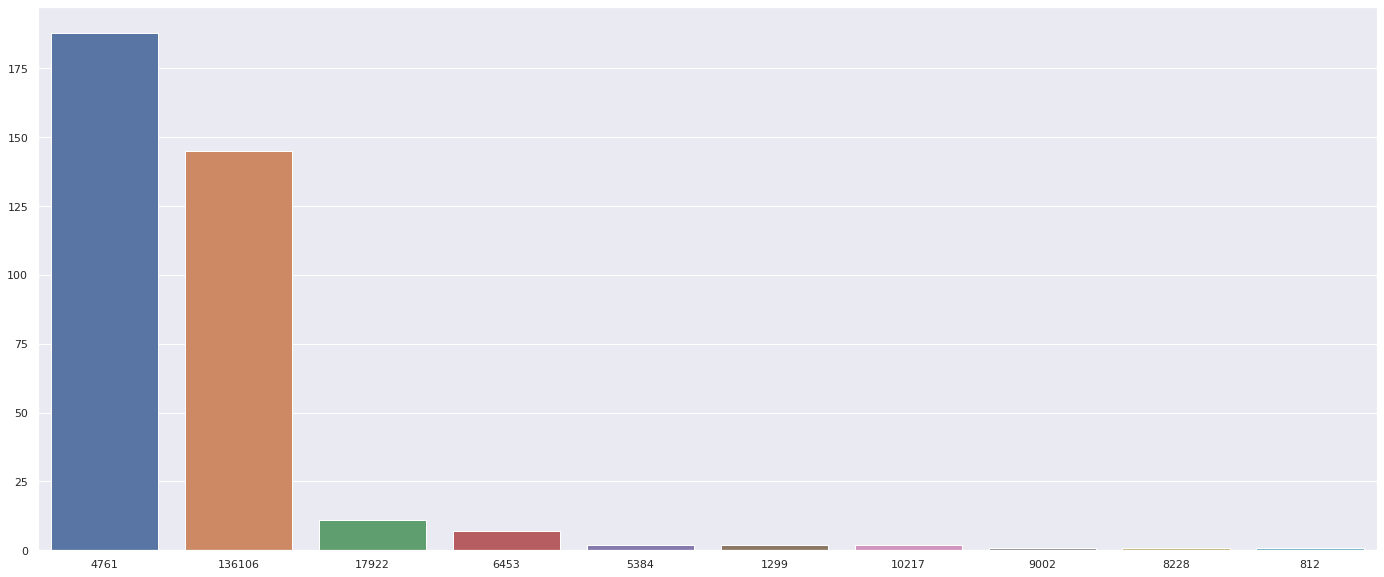

In [4]:
probes_per_as = ProbesPerAS(df)
probes_per_as.plot()

##  RTT Multivariate Plot per probe

A plot where a higher round trip time results in a darker dot for a certain moment, the x-axis shows the time, the y-axis shows unique probes that the data is collected from. If there is a similar pattern (dots getting darker) over different probes, this means that the anomaly can be detected from different sensors and therefore is more likely to be an actual problem instead of just noise in the signal.

<AxesSubplot:xlabel='created', ylabel='normalized_probe_id'>

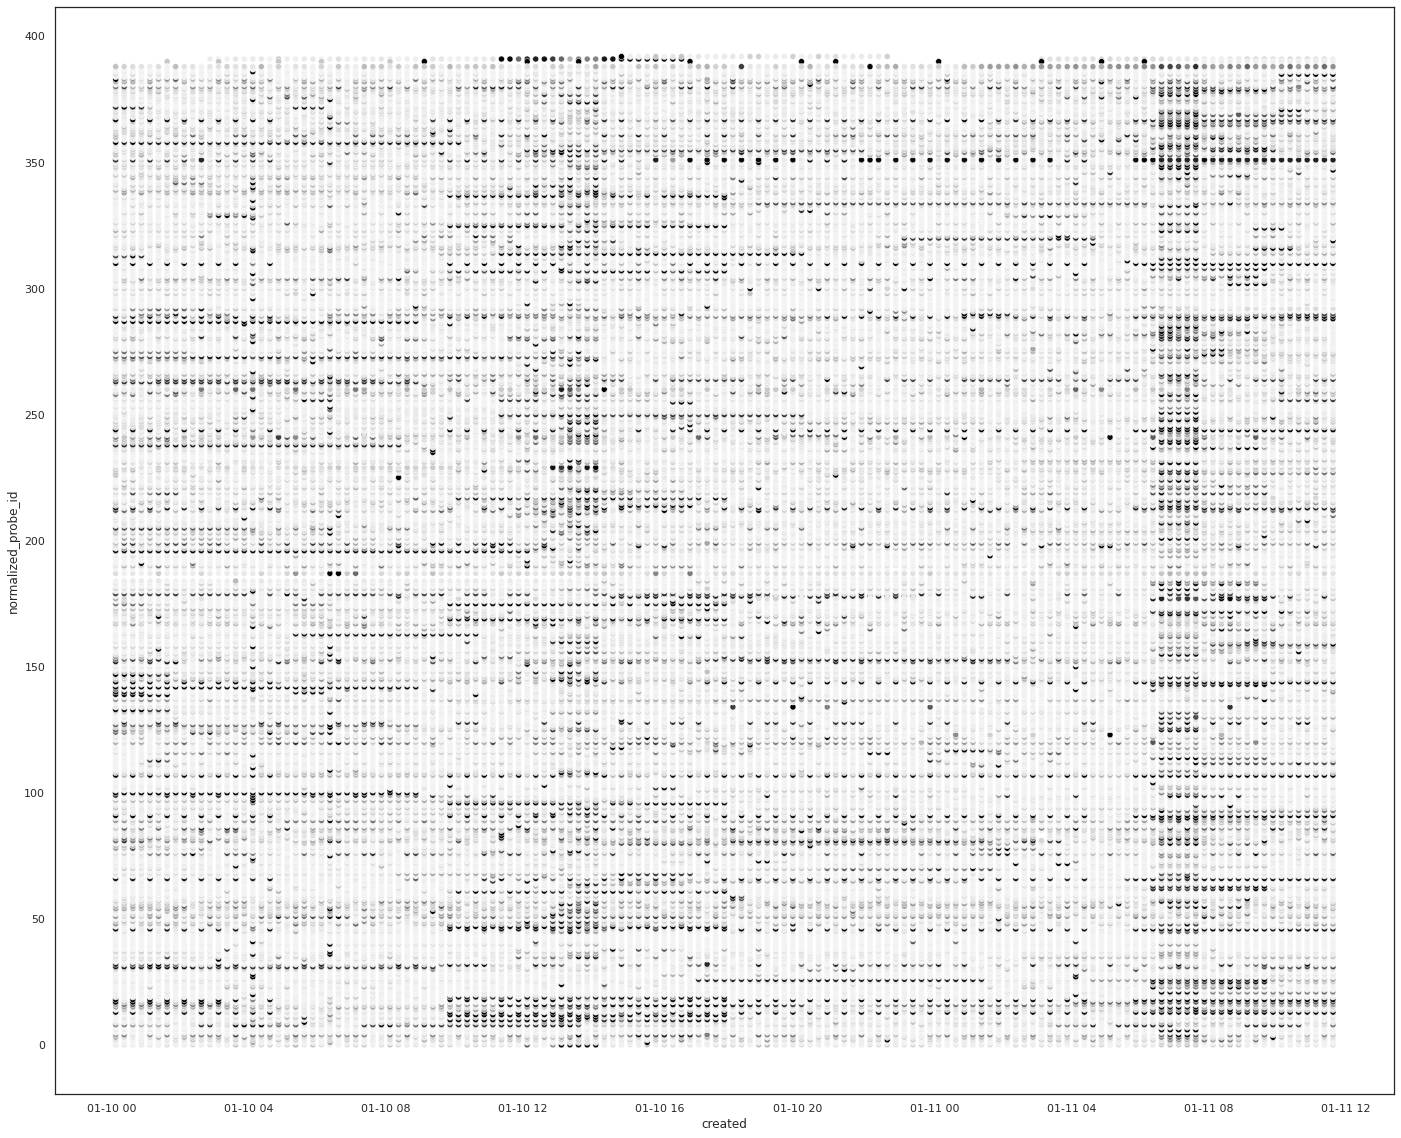

In [13]:
multivariate_plot = MultiVariatePlot(df)
multivariate_plot.plot_dataset()

##  RTT Multivariate Plot per AS number

A plot where a higher round trip time results in a darker dot for a certain moment, the x-axis shows the time, the y-axis shows probe-id's within a AS of neighboring connections.

<AxesSubplot:xlabel='created', ylabel='normalized_probe_id'>

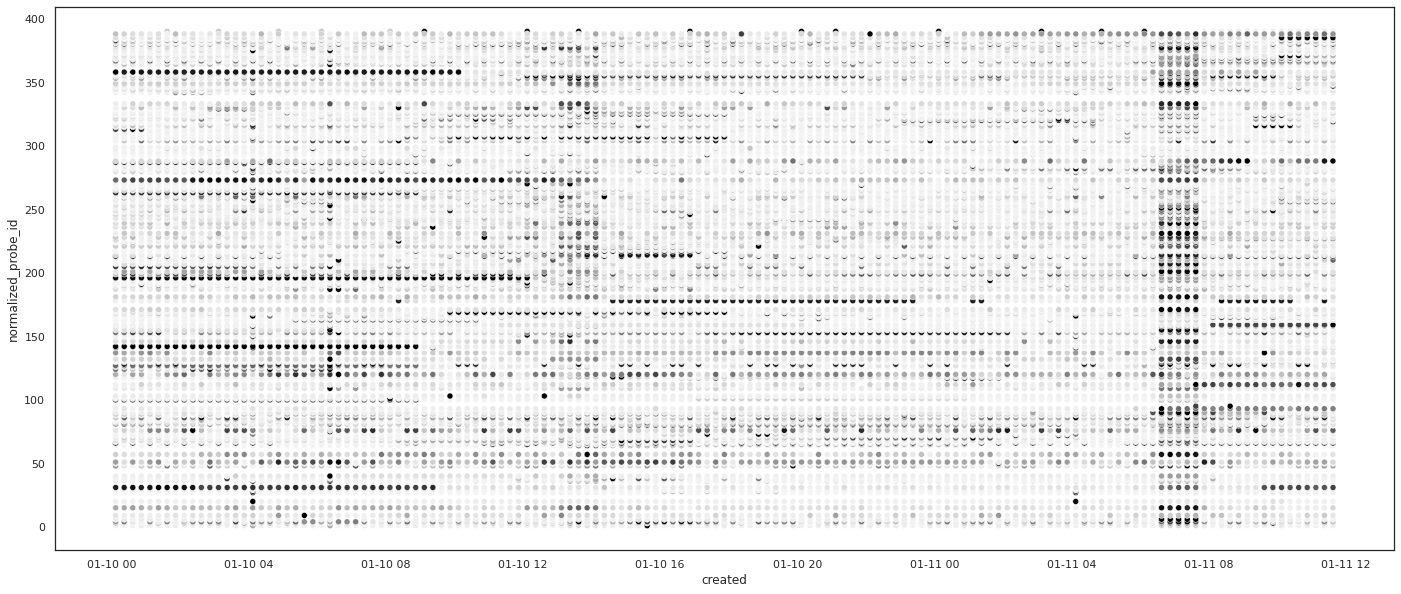

In [31]:
as_num = '4761'
multivariate_plot.plot_as(as_num=as_num)

## anomaly detection on single probe

The following section compares different anomaly detection algorithms. Since there is no ground truth data this has to happen visually by judging if the anomaly points line up with expectiations. An anomaly is either shown as a red dot or a red line.

The first code block allows the selection of a probe (either random, or select by choosing a probe id). After that there are graphs of different anomaly detection algorithms.

In [106]:
#interesting_random_state = {9, 13, 42, 46, 47}
random_probe = df["probe_id"].sample(n=1, random_state=105).unique()[0]
# random_probe = 6436
print(f"Probe ID: {random_probe}")
single_probe = df[df["probe_id"] == random_probe]

baseline = single_probe[single_probe['created'] < '2021-06-08']
check_range = single_probe[(single_probe['created'] < '2021-06-09') & (single_probe['created'] > '2021-06-08')]

Probe ID: 14631


### Isolation Forest

Algorithm based on decison tree's from Scikit learn

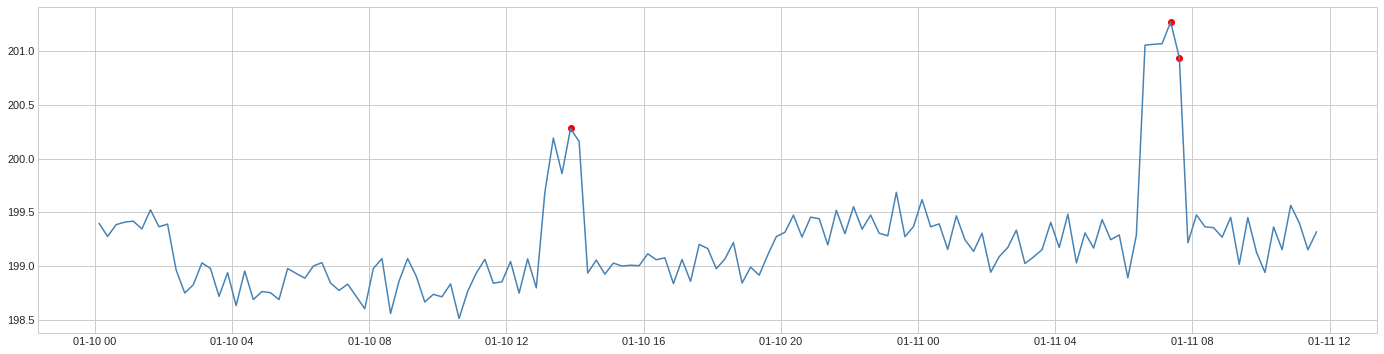

Run Time: 0.3499925549986074


In [107]:
start_if = perf_counter()
if_clf = IsolationForest(contamination=0.02)
single_probe["isolation_forest"] = if_clf.fit_predict(single_probe[["pre_entry_hop_min_rtt"]])
lenght_if = perf_counter() - start_if

fig, ax = plt.subplots(figsize=(24,6))

isolation_f = single_probe.loc[single_probe['isolation_forest'] == -1, ['created', 'pre_entry_hop_min_rtt']]
ax.scatter(isolation_f["created"], isolation_f["pre_entry_hop_min_rtt"], color="red")

# ax.plot(check_range['created'], check_range['pre_entry_hop_mean_rtt'], color='lightgrey')
ax.plot(single_probe['created'], single_probe['pre_entry_hop_min_rtt'], color='steelblue')

plt.show()
print(f'Run Time: {lenght_if}')

### Luminol

Algorithm developed by Linkedin

8.646774579973226
Run Time: 0.0020910150051349774


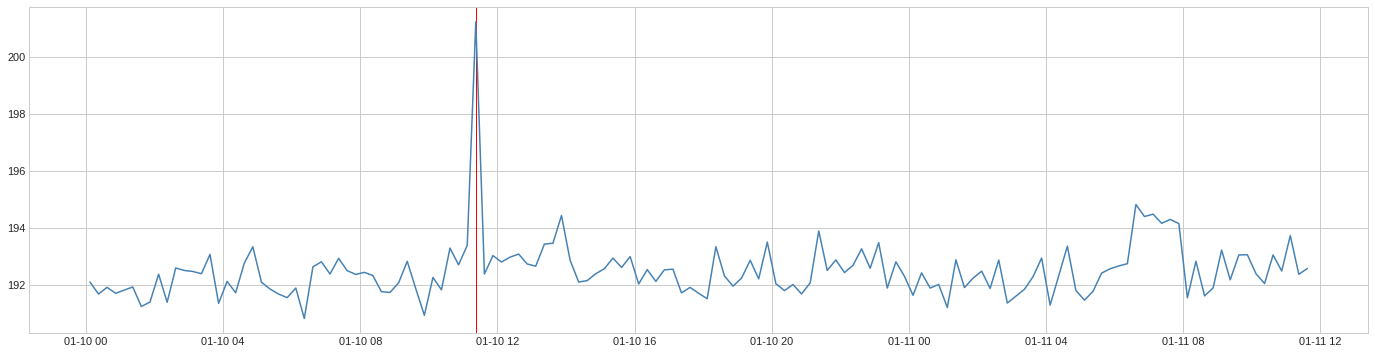

In [68]:
# Anomaly detection settings
algo_settings = {
        'smoothing_factor': 0.01,
    }

start_luminol = perf_counter()
# ts_baseline = baseline["pre_entry_hop_min_rtt"].to_dict()
ts_check = single_probe["pre_entry_hop_min_rtt"].to_dict()
detector = AnomalyDetector(ts_check, algorithm_name="exp_avg_detector", algorithm_params=algo_settings)
anomalies = detector.get_anomalies()
lenght_luminol = perf_counter() - start_luminol

for anomaly in anomalies:
    print(anomaly.anomaly_score)
fig, ax = plt.subplots(figsize=(24,6))

for anomaly in anomalies:
    start = single_probe.at[anomaly.start_timestamp, "created"]
    end = single_probe.at[anomaly.end_timestamp, "created"]
    score = anomaly.anomaly_score
    ax.axvspan(xmin=start, xmax=end, color="red")

# ax.plot(check_range['created'], check_range['pre_entry_hop_mean_rtt'], color='lightgrey')
ax.plot(single_probe['created'], single_probe['pre_entry_hop_min_rtt'], color='steelblue')

print(f'Run Time: {lenght_luminol}')

In [108]:
from adtk.data import validate_series
from adtk.visualization import plot

# Convert for the anomaly detection toolkit
single_probe.set_index('created', inplace=True)
ts = single_probe['pre_entry_hop_min_rtt']
ts = validate_series(ts)

### Inter Quartile Range

From the anomaly detection toolkit.

Run Time: 0.008601763998740353


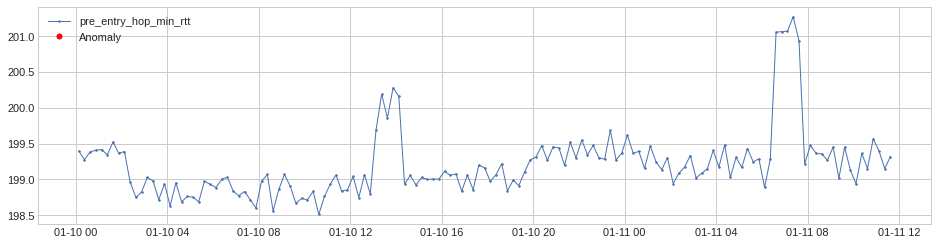

In [109]:
start = perf_counter()
iqr_ad = InterQuartileRangeAD(c=50)
iqr_anomalies = iqr_ad.fit_detect(ts)
lenght = perf_counter() - start

plot(ts, anomaly=iqr_anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
print(f'Run Time: {lenght}')

### Persist AD

Anomaly detection toolkit

Run Time: 0.022407051001209766


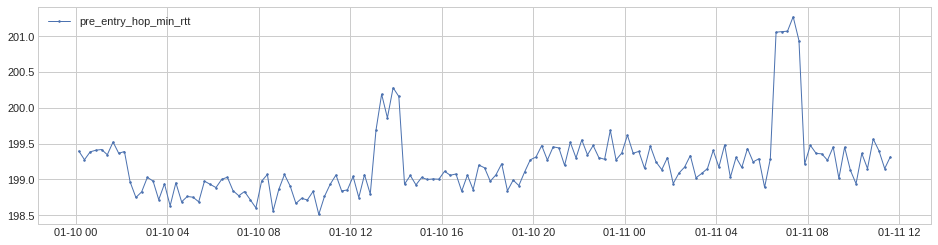

In [110]:
start = perf_counter()
persist_ad = PersistAD(c=20.0, side='positive', window=3)
persist_anomalies = persist_ad.fit_detect(ts)
lenght = perf_counter() - start

plot(ts, anomaly=persist_anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red')
print(f'Run Time: {lenght}')

### Level Shift

Anomaly Detection Toolkit

Run Time: 0.027472154994029552


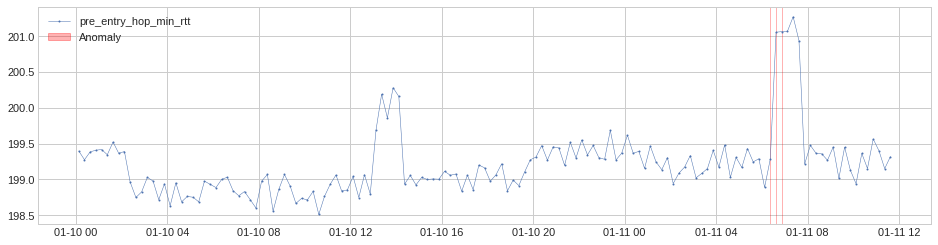

In [111]:
start = perf_counter()
level_shift_ad = LevelShiftAD(c=10.0, side='positive', window=3)
level_anomalies = level_shift_ad.fit_detect(ts)
lenght = perf_counter() - start

plot(ts, anomaly=level_anomalies, anomaly_color='red')
print(f'Run Time: {lenght}')

## Use ADTK detectors on entire dataset

To gain insight into how the different detection algorithms perform on the entire dataset, and to be able to see if there are interesting results in for an AS, the following section executes the detection on all probes in the dataset.

In [37]:
iqr_ad = InterQuartileRangeAD(c=10)
level_shift = LevelShiftAD(c=10.0, side='positive', window=3)
persist_ad = PersistAD(c=10.0, side='positive', window=3)

df_outlier = pd.DataFrame()
for probe_id in df["probe_id"].unique():
    # print(probe_id)
    single_probe = df[df["probe_id"] == probe_id]

    single_probe.set_index('created', inplace=True)
    ts = single_probe['pre_entry_hop_min_rtt']
    ts = validate_series(ts)

    try:
        single_probe["inter_quartile"] = iqr_ad.fit_detect(ts)
        single_probe["persist"] = persist_ad.fit_detect(ts)
        single_probe["level_shift"] = level_shift.fit_detect(ts)
        df_outlier = df_outlier.append(single_probe)
    except RuntimeError:
        pass

df_outlier

,probe_id,total_hops,pre_entry_hop_min_rtt,pre_entry_hop_ip,pre_entry_as,inter_quartile,persist,level_shift
created,,,,,,,,
2022-01-10 00:07:08+00:00,1000067,14,184.710,103.87.184.123,136106,False,NaN,NaN
2022-01-10 00:22:13+00:00,1000067,14,184.713,103.87.184.123,136106,False,NaN,NaN
2022-01-10 00:37:08+00:00,1000067,14,184.601,103.87.184.123,136106,False,NaN,NaN
2022-01-10 00:52:09+00:00,1000067,14,184.693,103.87.184.123,136106,False,False,False
2022-01-10 01:07:13+00:00,1000067,14,184.709,103.87.184.123,136106,False,False,False
...,...,...,...,...,...,...,...,...
2022-01-10 21:37:04+00:00,14277,14,257.608,116.0.74.7,6453,False,False,False
2022-01-10 21:52:09+00:00,14277,15,257.492,180.87.67.32,6453,False,False,False
2022-01-10 22:07:10+00:00,14277,14,257.109,116.0.74.9,6453,False,False,False


## Aggregate anomalies in single AS

The following plots are aggregated results for the different anomaly detection methods. Meaning that if multiple probes are marked as anomalous at the same time, there will be a peak in the anomaly score for the entire AS. This makes sense, the likelihood of an actual problem is larger if multiple probes detect delays at the same time.

<AxesSubplot:xlabel='created'>

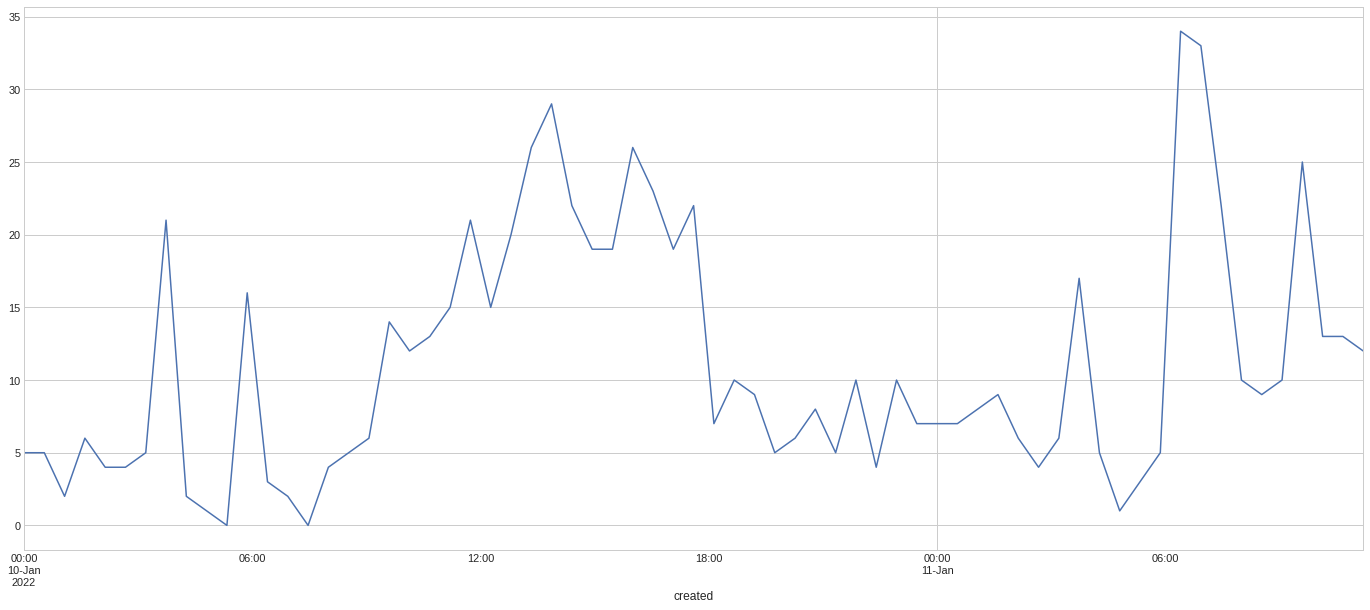

In [38]:
as_num = '4761'
single_as_df = df_outlier[df_outlier['pre_entry_as'] == as_num]
single_as_df
single_as_df.groupby(pd.Grouper(freq="32T"))["inter_quartile"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

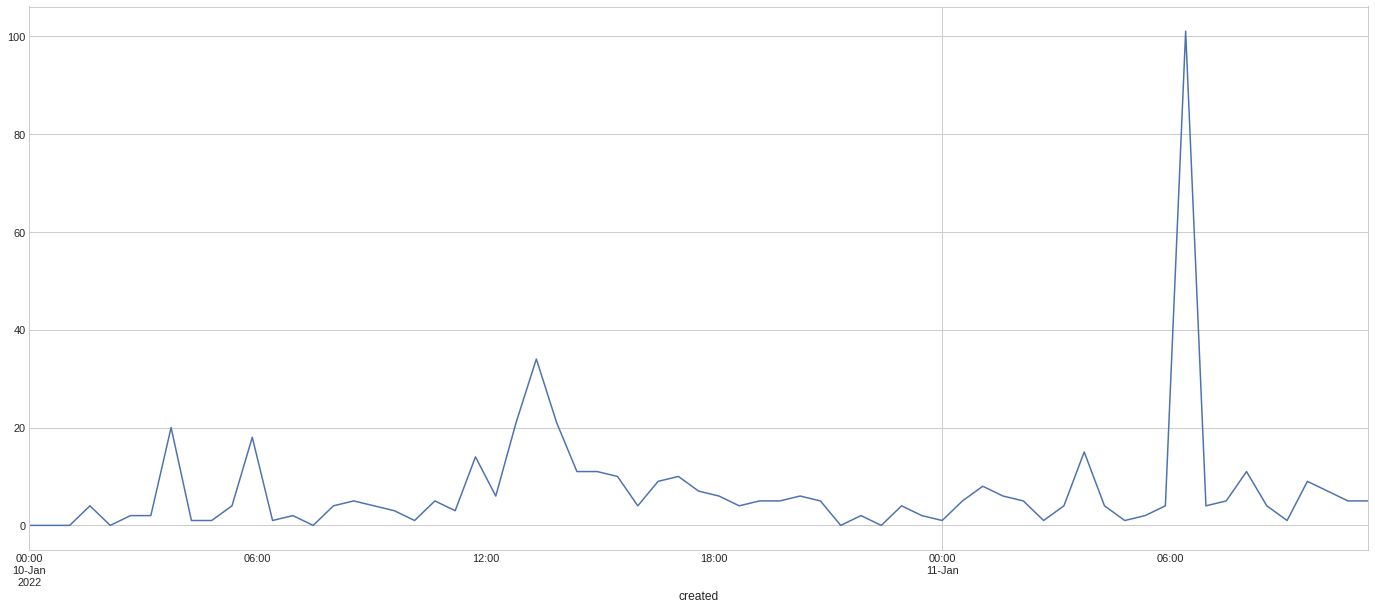

In [35]:
as_num = '4761'
single_as_df = df_outlier[df_outlier['pre_entry_as'] == as_num]
single_as_df
single_as_df.groupby(pd.Grouper(freq="32T"))["persist"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

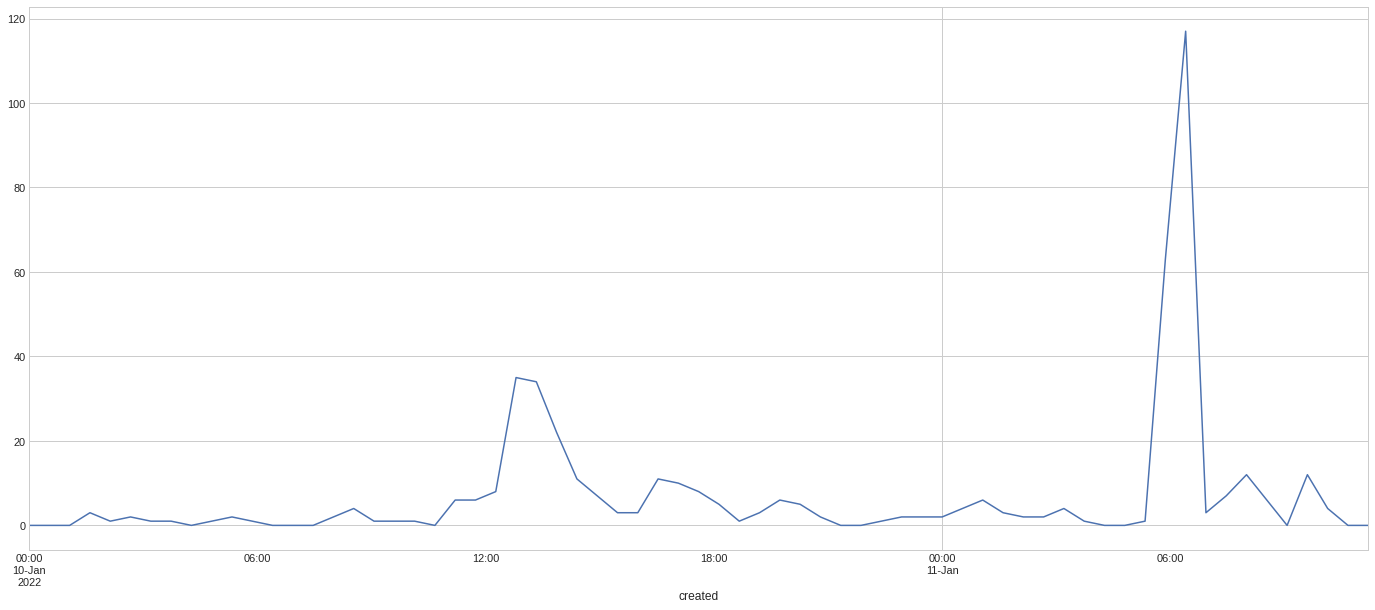

In [36]:
as_num = '4761'
single_as_df = df_outlier[df_outlier['pre_entry_as'] == as_num]
single_as_df
single_as_df.groupby(pd.Grouper(freq="32T"))["level_shift"].agg("sum").plot()

# Conclusion

The level shift detector seems to give the best results (Most inline with expectations based on the multivariate plot). This will be the detector we will use for now moving forward.